# Plots (Model)

In [1]:
import sys
import os

# Get the parent directory of the current directory (subdir2)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from pmf import PMFModel
from rdpg import aip, cosie
from utils.data import convert_data

from report.real_world_data.plots import (
    pictures_folder_path,
    num_train,
    num_test,
    plot_eval,
    sample_indices_test_data,
    compute_model_predictions,
    compute_fpr_tpr_auc_aip,
    compute_fpr_tpr_auc_cosie,
    compute_fpr_tpr_auc_model,
    plot_diff_auc_values,
)

In [3]:
# Set the Computer Modern font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern"
plt.rcParams["text.usetex"] = True

In [4]:
# Load the data from the pickle file
with open("huxley_2020.pkl", "rb") as stream:
    data = pickle.load(stream)

# Convert the data to the format expected by the model
data = convert_data(data)

# Extract the adjacency matrix shape
adj_shape = data[0].shape

# Extract the training and test data
train_data = data[:num_train]
test_data = data[num_train:]

print(data)
print(train_data)
print(test_data)

<COO: shape=(14, 164, 250), dtype=int32, nnz=32641, fill_value=0>
<COO: shape=(10, 164, 250), dtype=int32, nnz=24280, fill_value=0>
<COO: shape=(4, 164, 250), dtype=int32, nnz=8361, fill_value=0>


In [5]:
# Set the number of latent features
d = 7

In [6]:
# Load the model
model = PMFModel.load("model.pkl")

Model loaded from model.pkl!


## ELBO and Log-likelihood plots

In [7]:
print(f"Min difference ELBO: {np.min(np.diff(model.cavi_results.elbo_values))}")

Min difference ELBO: 0.6125375868796255


In [8]:
(model.cavi_results.elbo_values[-1] - model.cavi_results.elbo_values[-2]) / model.cavi_results.elbo_values[-2]

-1.2739027036962968e-05

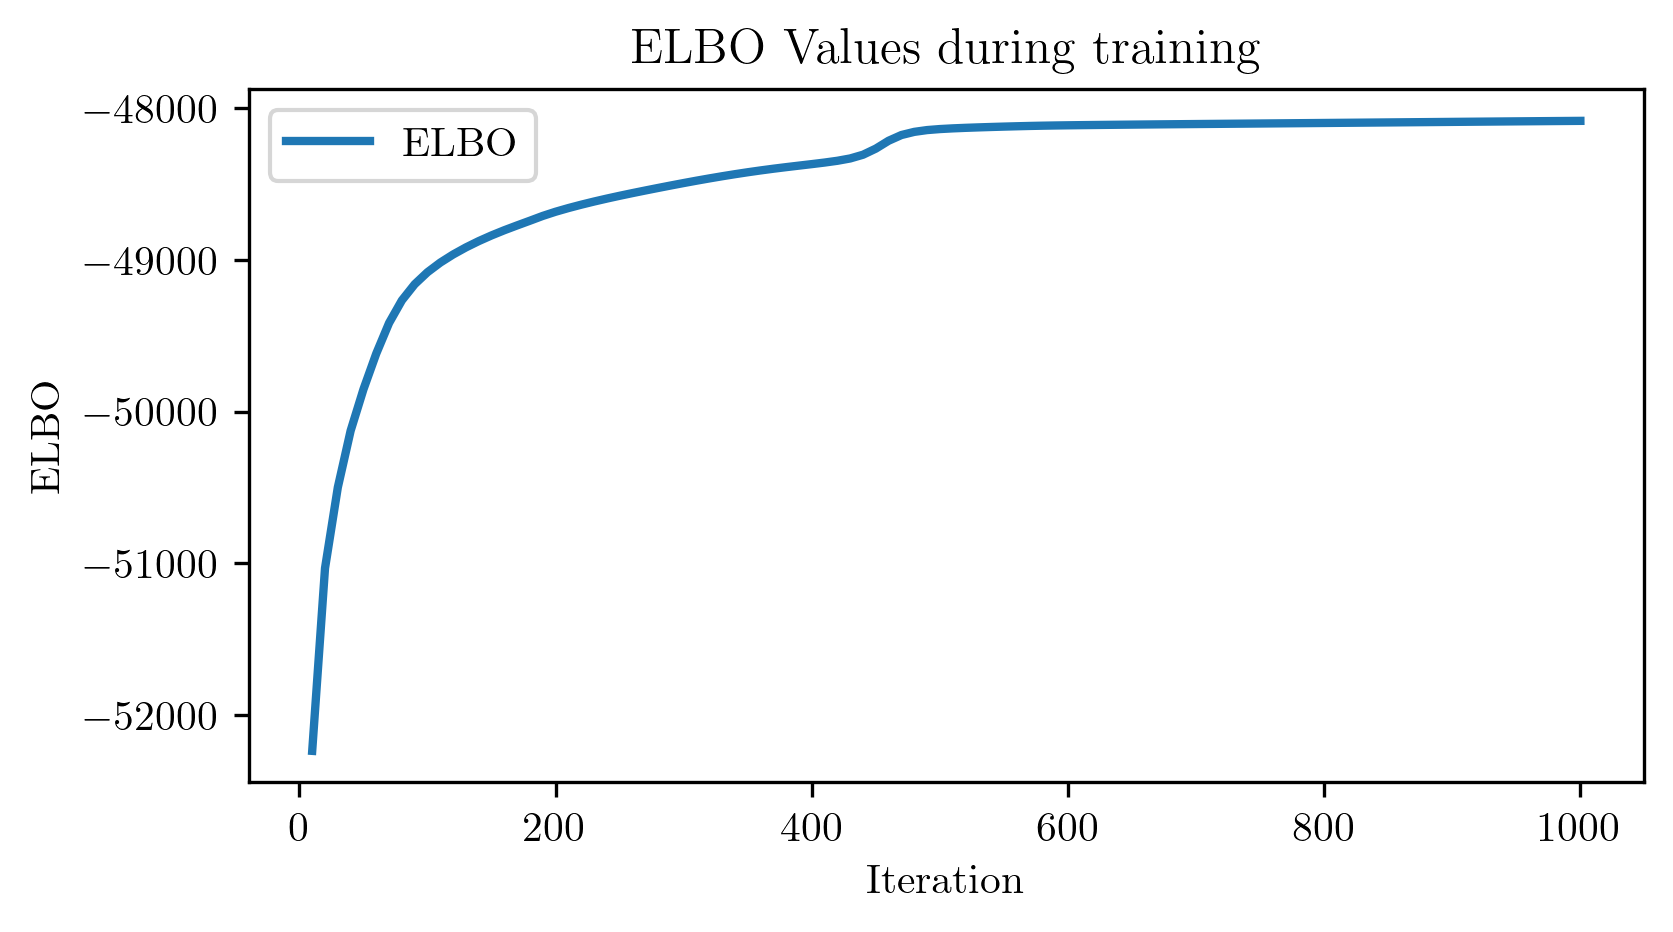

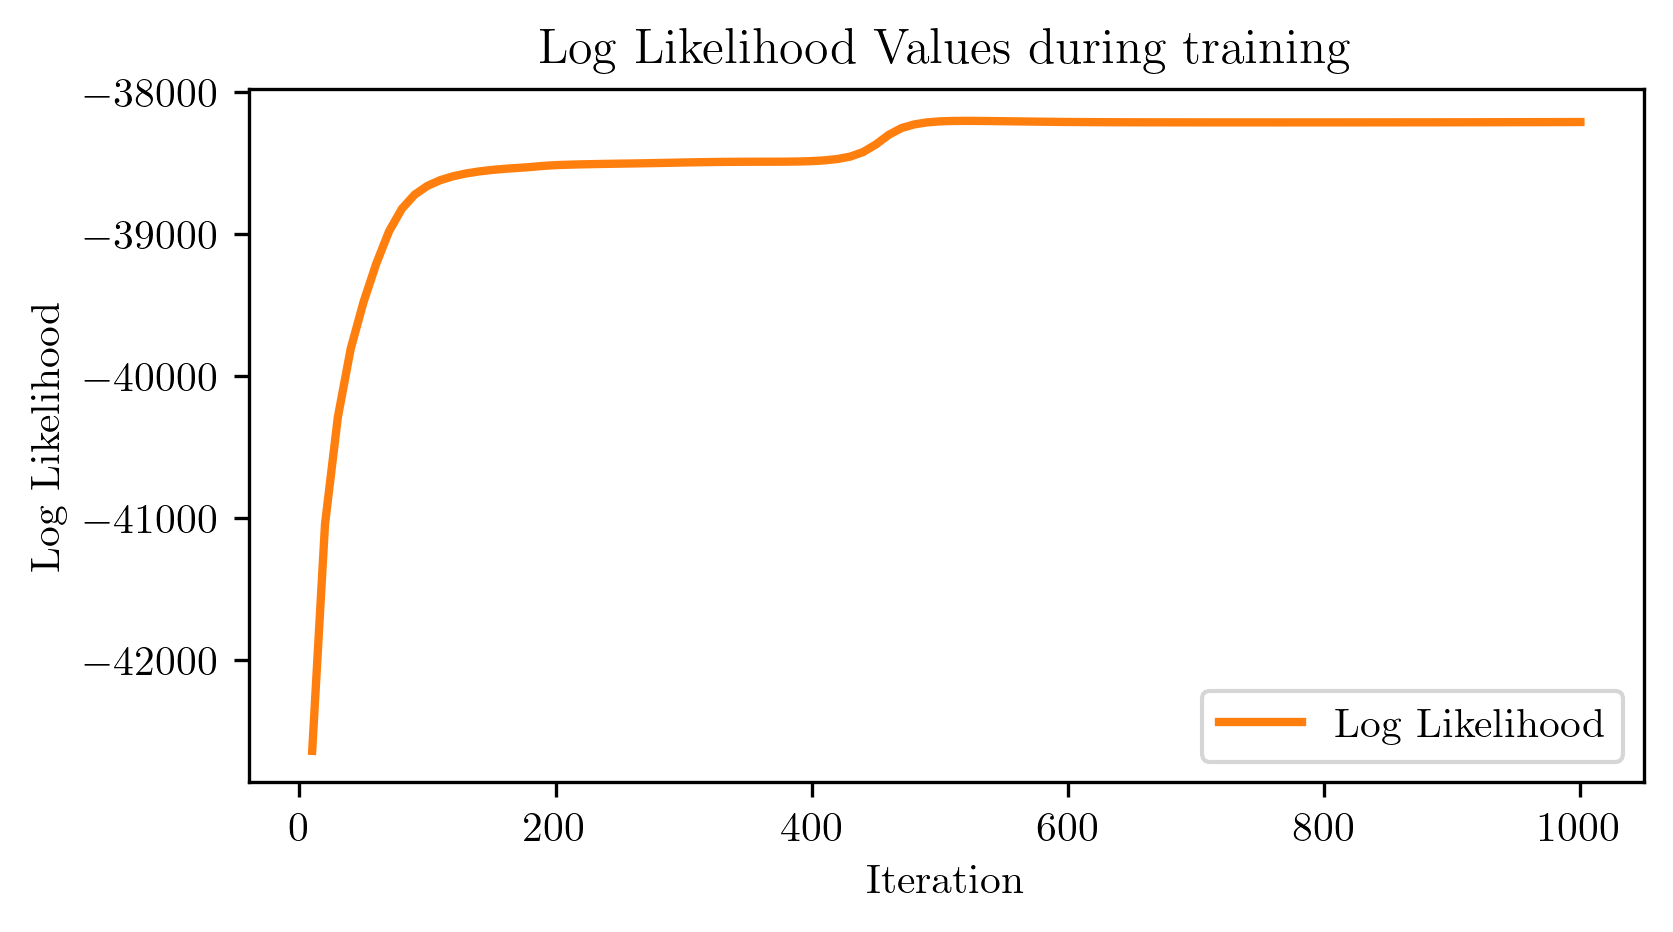

In [9]:
# Use a color-blind friendly palette
colors = plt.get_cmap("tab10").colors

plot_eval(model, "elbo", colors[0])
plot_eval(model, "log-likelihood", colors[1])

## Model Performance

In [10]:
# Compute all the AIP predictions
aip_train_data = [train_data[i] for i in range(num_train)]
aip_all_predictions = np.zeros((num_test, *adj_shape))
for time_step in range(num_test):
    aip_all_predictions[time_step] = aip(
        aip_train_data, num_eigenvalues=d, rng=np.random.default_rng(43)
    )
    aip_train_data.append(aip_all_predictions[time_step])

In [11]:
# Compute all the COSIE predictions
cosie_train_data = [train_data[i] for i in range(num_train)]
cosie_all_predictions = np.zeros((num_test, *adj_shape))
for time_step in range(num_test):
    cosie_all_predictions[time_step] = cosie(
        cosie_train_data, num_eigenvalues=d, rng=np.random.default_rng(43)
    )
    cosie_train_data.append(cosie_all_predictions[time_step])

In [12]:
# Samples some indices for the test data
test_indices_axis0, test_indices_axis1 = sample_indices_test_data(test_data)

# Compute the model's predictions
model_predictions = compute_model_predictions(model, test_indices_axis0, test_indices_axis1)

# Compute the AUC values
_, _, baseline_aip_auc_values = compute_fpr_tpr_auc_aip(
    test_data, test_indices_axis0, test_indices_axis1, aip_all_predictions
)
_, _, baseline_cosie_auc_values = compute_fpr_tpr_auc_cosie(
    test_data, test_indices_axis0, test_indices_axis1, cosie_all_predictions
)
_, _, baseline_model_auc_values = compute_fpr_tpr_auc_model(
    model_predictions, test_data, test_indices_axis0, test_indices_axis1
)

Time step 1
total: 7752; positive: 2752; negative: 5000
Time step 2
total: 7776; positive: 2776; negative: 5000
Time step 3
total: 6370; positive: 1370; negative: 5000
Time step 4
total: 6463; positive: 1463; negative: 5000


In [13]:
table_values = [
    ["Model", *baseline_model_auc_values],
    ["COSIE", *baseline_cosie_auc_values],
    ["AIP", *baseline_aip_auc_values],
]
table = tabulate(
    table_values,
    headers=["AUC Score", "t = 11", "t = 12", "t = 13", "t = 14"],
    tablefmt="fancy_grid",
)

print("AUC scores across different days")
print(table)

AUC scores across different days
╒═════════════╤══════════╤══════════╤══════════╤══════════╕
│ AUC Score   │   t = 11 │   t = 12 │   t = 13 │   t = 14 │
╞═════════════╪══════════╪══════════╪══════════╪══════════╡
│ Model       │ 0.888142 │ 0.855364 │ 0.922669 │ 0.902421 │
├─────────────┼──────────┼──────────┼──────────┼──────────┤
│ COSIE       │ 0.886986 │ 0.852873 │ 0.923021 │ 0.894219 │
├─────────────┼──────────┼──────────┼──────────┼──────────┤
│ AIP         │ 0.870586 │ 0.840605 │ 0.91593  │ 0.888248 │
╘═════════════╧══════════╧══════════╧══════════╧══════════╛


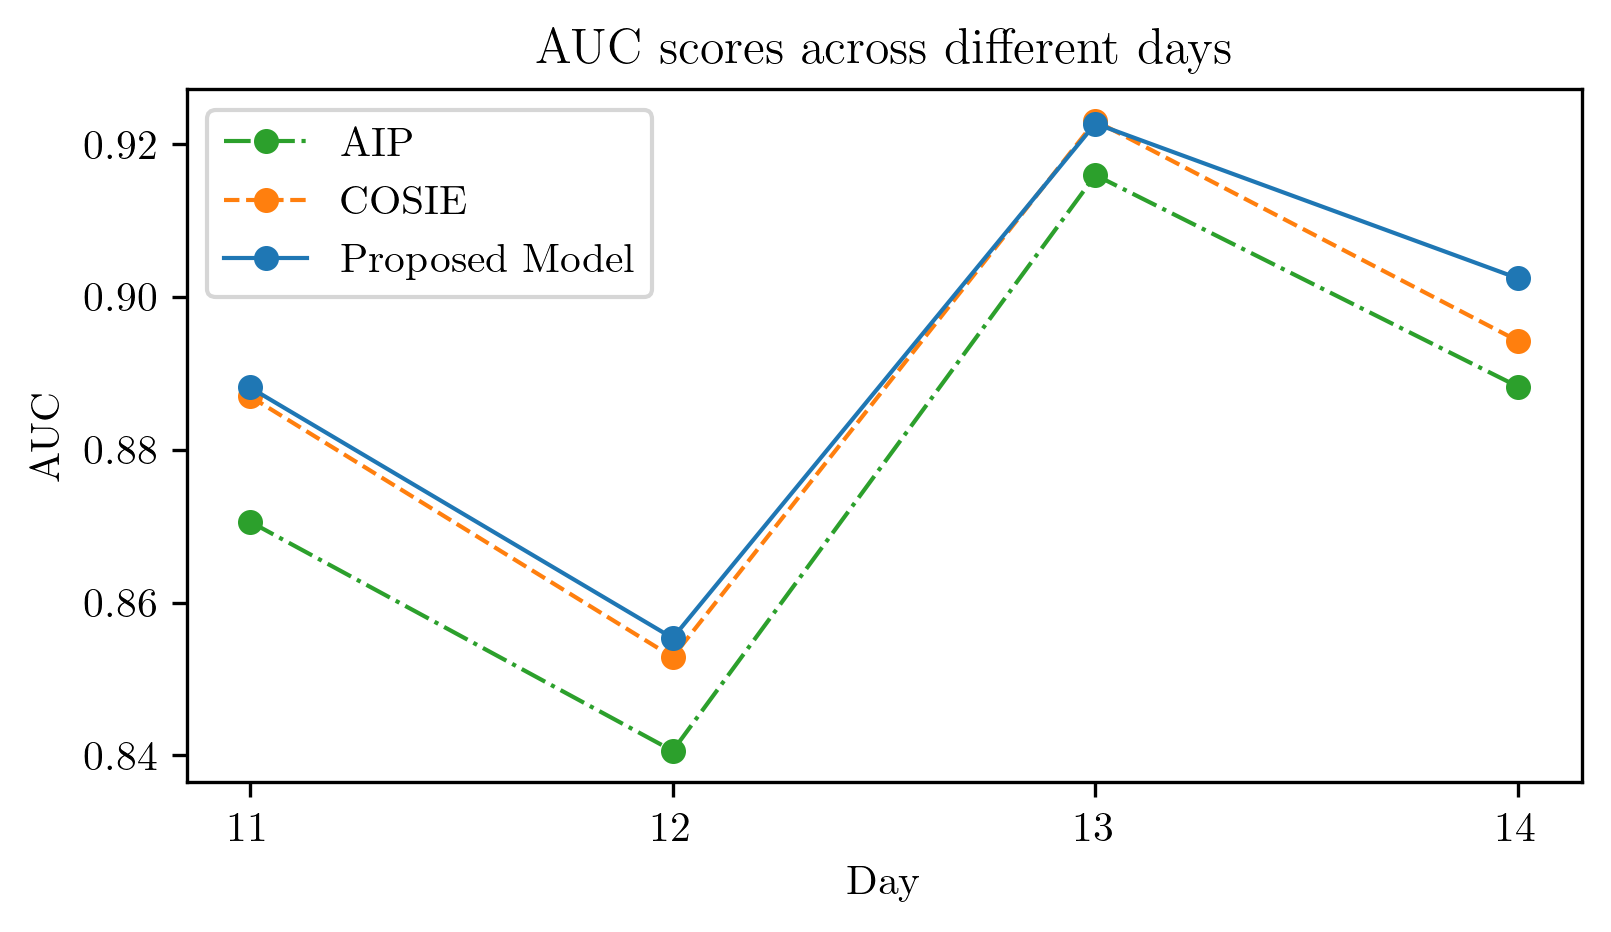

In [14]:
def plot_auc_values(
    range,
    model_auc_values,
    cosie_auc_values,
    aip_auc_values,
    title: str,
    xlabel: str,
    file_name: str,
):
    # Use a color-blind friendly palette
    colors = plt.get_cmap("tab10").colors

    plt.figure(figsize=(6, 3), dpi=300)

    plt.plot(
        range,
        aip_auc_values,
        label="AIP",
        color=colors[2],
        linestyle="-.",
        linewidth=1,
        marker="o",
        markersize=5,
    )
    plt.plot(
        range,
        cosie_auc_values,
        label="COSIE",
        color=colors[1],
        linestyle="--",
        linewidth=1,
        marker="o",
        markersize=5,
    )
    plt.plot(
        range,
        model_auc_values,
        label="Proposed Model",
        color=colors[0],
        linestyle="-",
        linewidth=1,
        marker="o",
        markersize=5,
    )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(range)
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(False)

    plt.savefig(
        os.path.join(pictures_folder_path, file_name),
        format="pdf",
        bbox_inches="tight",
    )

    plt.show()


plot_auc_values(
    range=np.arange(num_test) + num_train + 1,
    model_auc_values=baseline_model_auc_values,
    cosie_auc_values=baseline_cosie_auc_values,
    aip_auc_values=baseline_aip_auc_values,
    title="AUC scores across different days",
    xlabel="Day",
    file_name="auc.pdf",
)

## Model's performance on different levels of activity

In [15]:
# Compute the users and servers activity
users_activity = np.sum(np.sum(train_data, axis=2) > 0, axis=0).todense() # shape (num_users, )
servers_activity = np.sum(np.sum(train_data, axis=1) > 0, axis=0).todense() # shape (num_servers, )

# Calculate the frequency of each activity level
users_activity_counts = np.bincount(users_activity, minlength=num_train + 1) # shape (num_train + 1, )
servers_activity_counts = np.bincount(servers_activity, minlength=num_train + 1) # shape (num_train + 1, )

# Calculate the density of each activity level
users_activity_density = users_activity_counts / np.sum(users_activity_counts) # shape (num_train + 1, )
servers_activity_density = servers_activity_counts / np.sum(servers_activity_counts) # shape (num_train + 1, )

print(users_activity)
print(servers_activity)

print()

print(users_activity_counts)
print(servers_activity_counts)

print()

print(users_activity_density)
print(servers_activity_density)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  8 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10  9  9 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10  7 10 10 10 10 10  9 10 10
 10 10 10 10 10 10  0  3  0  3  1  0  5  1  0  7  0  3  1  0]
[ 6  6 10 10 10  6  9 10 10 10  6  8 10 10  6  3 10 10  5  6  8  7  9  7
  8  7  9 10 10 10  6  9  6  8  6 10  7  9  6 10  8 10  8 10  7 10  7  7
 10  7  7 10  8  8  8 10  8  5  9 10  9  6  6 10  9 10  8 10 10 10  7  7
  7  9  8  8  5  6  6 10  8  9 10 10 10 10 10  8 10 10 10 10  7  9  7  9
  9  8 10 10  7  6  8 10  8  6 10  9  6  8 10  7  5  8 10  9  9  7  9 10
  9  6  7  7  8  8 10 10  7  6  7  5  8  7 10  6  8  8  9  8  8  7 10  7
  9  6 10 10 10  9 10 10  9  6  8 10  9  6 10  9  8  4  7  7  

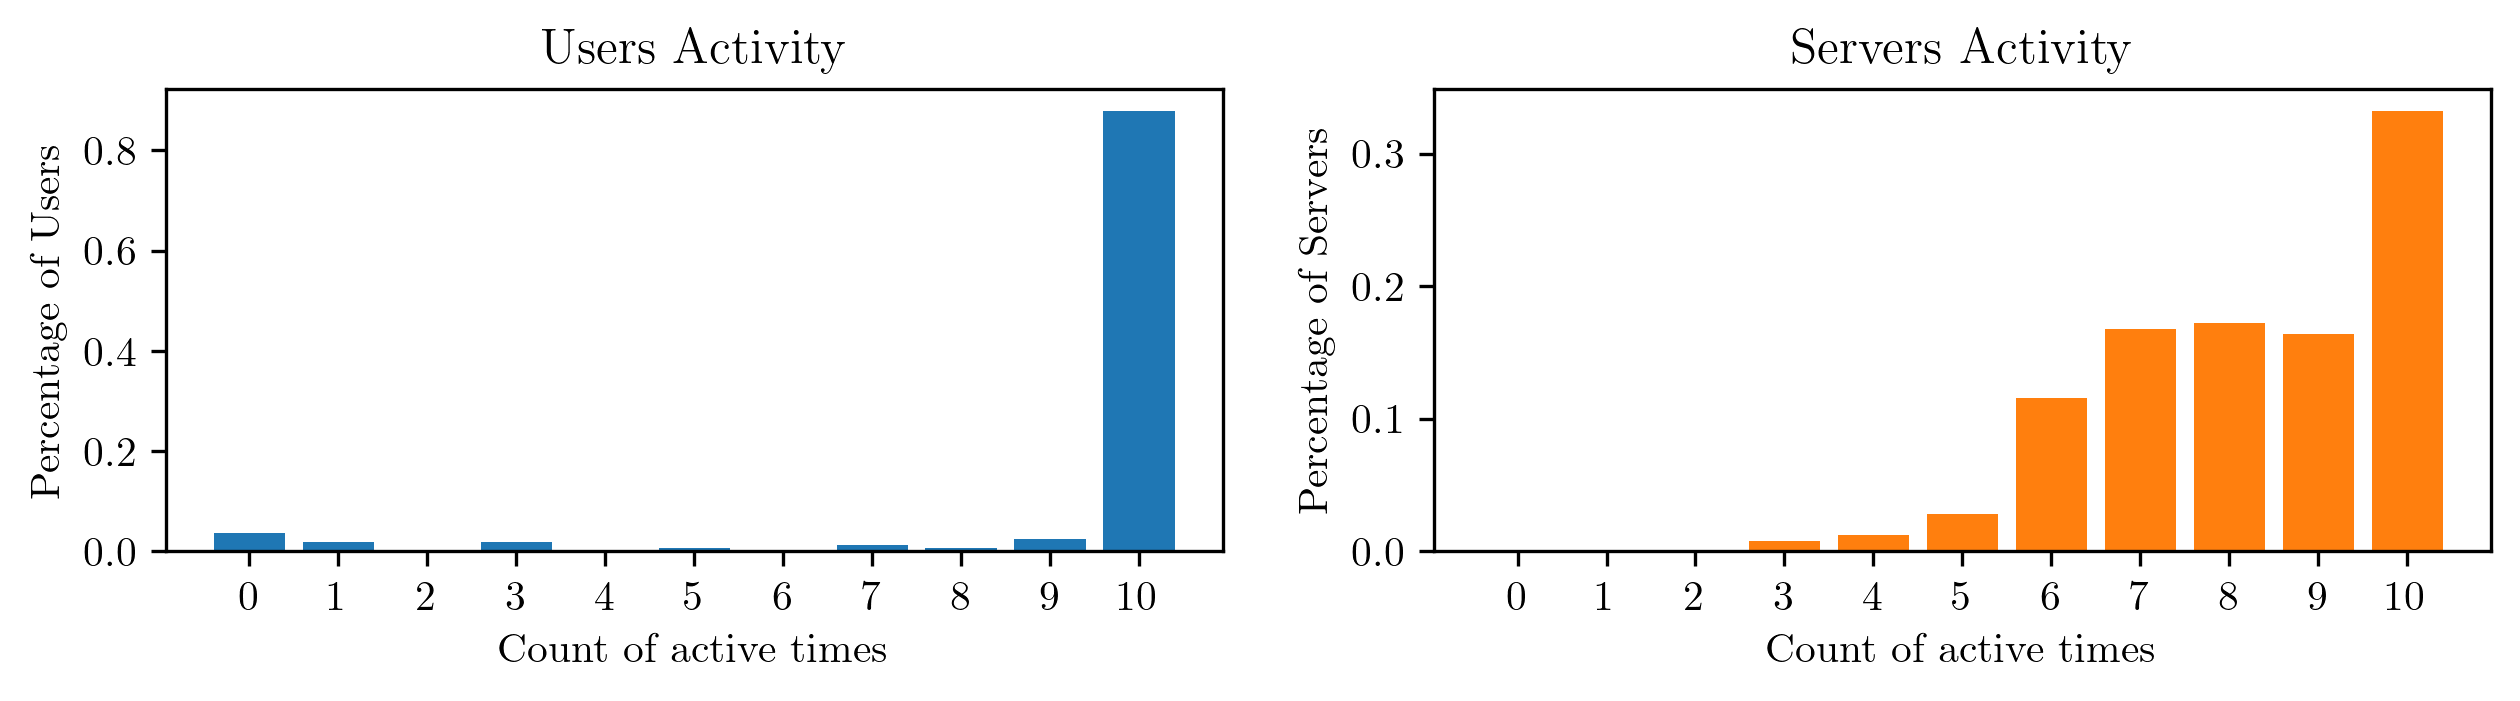

In [16]:
# Create the possible activity levels
possible_activity_level = range(num_train + 1)

# Use a color-blind friendly palette
colors = plt.get_cmap("tab10").colors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), dpi=300)

# Histogram for users_activity
ax1.bar(possible_activity_level, users_activity_density, color=colors[0])
ax1.set_title("Users Activity")
ax1.set_xlabel("Count of active times")
ax1.set_ylabel("Percentage of Users")
ax1.set_xticks(possible_activity_level)
ax1.grid(False)

# Histogram for servers_activity
ax2.bar(possible_activity_level, servers_activity_density, color=colors[1])
ax2.set_title("Servers Activity")
ax2.set_xlabel("Count of active times")
ax2.set_ylabel("Percentage of Servers")
ax2.set_xticks(possible_activity_level)
ax2.grid(False)

plt.savefig(
    os.path.join(pictures_folder_path, "activity-levels.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()

In [17]:
# Find the activity levels with non-zero density
nonzero_users_activity_levels = np.where(users_activity_density > 0)[0]
nonzero_servers_activity_level = np.where(servers_activity_density > 0)[0]

print(f"non zero users activity levels: {nonzero_users_activity_levels}")
print(f"non zero servers activity levels: {nonzero_servers_activity_level}")

non zero users activity levels: [ 0  1  3  5  7  8  9 10]
non zero servers activity levels: [ 3  4  5  6  7  8  9 10]


In [18]:
aip_auc_values_servers = np.zeros((len(nonzero_servers_activity_level), num_test))
cosie_auc_values_servers = np.zeros((len(nonzero_servers_activity_level), num_test))
model_auc_values_servers = np.zeros((len(nonzero_servers_activity_level), num_test))

for i, server_activity_level in enumerate(nonzero_servers_activity_level):
    print(f"Server activity level: {server_activity_level}")

    # Find the indices of the servers with the given activity level
    server_indices = np.where(servers_activity == server_activity_level)[0]

    # Extract the test data for the servers with the given activity level
    filtered_test_data = test_data[:, :, server_indices]

    # Samples some indices for the test data
    test_indices_axis0, test_indices_axis1 = sample_indices_test_data(
        filtered_test_data
    )

    # Compute the model's predictions
    model_predictions = compute_model_predictions(
        model, test_indices_axis0, test_indices_axis1
    )

    # Compute the AUC values
    _, _, aip_auc_values_servers[i] = compute_fpr_tpr_auc_aip(
        filtered_test_data, test_indices_axis0, test_indices_axis1, aip_all_predictions
    )
    _, _, cosie_auc_values_servers[i] = compute_fpr_tpr_auc_cosie(
        filtered_test_data,
        test_indices_axis0,
        test_indices_axis1,
        cosie_all_predictions,
    )
    _, _, model_auc_values_servers[i] = compute_fpr_tpr_auc_model(
        model_predictions, filtered_test_data, test_indices_axis0, test_indices_axis1
    )

    print()

# Transpose the AUC arrays
aip_auc_values_servers = np.transpose(
    aip_auc_values_servers
)  # shape (num test points, num nonzero servers activity levels)
cosie_auc_values_servers = np.transpose(
    cosie_auc_values_servers
)  # shape (num test points, num nonzero servers activity levels)
model_auc_values_servers = np.transpose(
    model_auc_values_servers
)  # shape (num test points, num nonzero servers activity levels)

Server activity level: 3
Time step 1
total: 328; positive: 12; negative: 316
Time step 2
total: 328; positive: 7; negative: 321
Time step 3
total: 328; positive: 1; negative: 327
Time step 4
total: 328; positive: 3; negative: 325

Server activity level: 4
Time step 1
total: 492; positive: 8; negative: 484
Time step 2
total: 492; positive: 1; negative: 491
Time step 3
total: 492; positive: 2; negative: 490
Time step 4
total: 492; positive: 1; negative: 491

Server activity level: 5
Time step 1
total: 1148; positive: 12; negative: 1136
Time step 2
total: 1148; positive: 19; negative: 1129
Time step 3
total: 1148; positive: 3; negative: 1145
Time step 4
total: 1148; positive: 3; negative: 1145

Server activity level: 6
Time step 1
total: 4756; positive: 49; negative: 4707
Time step 2
total: 4756; positive: 44; negative: 4712
Time step 3
total: 4756; positive: 10; negative: 4746
Time step 4
total: 4756; positive: 10; negative: 4746

Server activity level: 7
Time step 1
total: 5164; positiv

In [19]:
aip_auc_values_users = np.zeros((len(nonzero_users_activity_levels), num_test))
cosie_auc_values_users = np.zeros((len(nonzero_users_activity_levels), num_test))
model_auc_values_users = np.zeros((len(nonzero_users_activity_levels), num_test))

for i, user_activity_level in enumerate(nonzero_users_activity_levels):
    print(f"User activity level: {user_activity_level}")

    # Find the indices of the users with the given activity level
    user_indices = np.where(users_activity == user_activity_level)[0]

    # Extract the test data for the users with the given activity level
    filtered_test_data = test_data[:, user_indices, :]

    # Samples some indices for the test data
    test_indices_axis0, test_indices_axis1 = sample_indices_test_data(
        filtered_test_data
    )

    # Compute the model's predictions
    model_predictions = compute_model_predictions(
        model, test_indices_axis0, test_indices_axis1
    )

    # Compute the AUC values
    _, _, aip_auc_values_users[i] = compute_fpr_tpr_auc_aip(
        filtered_test_data, test_indices_axis0, test_indices_axis1, aip_all_predictions
    )
    _, _, cosie_auc_values_users[i] = compute_fpr_tpr_auc_cosie(
        filtered_test_data,
        test_indices_axis0,
        test_indices_axis1,
        cosie_all_predictions,
    )
    _, _, model_auc_values_users[i] = compute_fpr_tpr_auc_model(
        model_predictions, filtered_test_data, test_indices_axis0, test_indices_axis1
    )

    print()

# Transpose the AUC arrays
aip_auc_values_users = np.transpose(
    aip_auc_values_users
)  # shape (num test points, num nonzero users activity levels)
cosie_auc_values_users = np.transpose(
    cosie_auc_values_users
)  # shape (num test points, num nonzero users activity levels)
model_auc_values_users = np.transpose(
    model_auc_values_users
)  # shape (num test points, num nonzero users activity levels)

User activity level: 0
Time step 1
total: 1500; positive: 8; negative: 1492
Time step 2
total: 1500; positive: 44; negative: 1456
Time step 3
total: 1500; positive: 16; negative: 1484
Time step 4
total: 1500; positive: 12; negative: 1488

User activity level: 1
Time step 1
total: 750; positive: 0; negative: 750
Time step 2
total: 750; positive: 42; negative: 708
Time step 3
total: 750; positive: 10; negative: 740
Time step 4
total: 750; positive: 14; negative: 736


c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



User activity level: 3
Time step 1
total: 750; positive: 23; negative: 727
Time step 2
total: 750; positive: 14; negative: 736
Time step 3
total: 750; positive: 14; negative: 736
Time step 4
total: 750; positive: 15; negative: 735

User activity level: 5
Time step 1
total: 250; positive: 22; negative: 228
Time step 2
total: 250; positive: 46; negative: 204
Time step 3
total: 250; positive: 5; negative: 245
Time step 4
total: 250; positive: 0; negative: 250


c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



User activity level: 7
Time step 1
total: 500; positive: 25; negative: 475
Time step 2
total: 500; positive: 15; negative: 485
Time step 3
total: 500; positive: 13; negative: 487
Time step 4
total: 500; positive: 13; negative: 487

User activity level: 8
Time step 1
total: 250; positive: 0; negative: 250
Time step 2
total: 250; positive: 29; negative: 221
Time step 3
total: 250; positive: 10; negative: 240
Time step 4
total: 250; positive: 6; negative: 244


c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\lenovo\Documents\GitHub\final-year-project\implementation\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



User activity level: 9
Time step 1
total: 1000; positive: 42; negative: 958
Time step 2
total: 1000; positive: 63; negative: 937
Time step 3
total: 1000; positive: 20; negative: 980
Time step 4
total: 1000; positive: 32; negative: 968

User activity level: 10
Time step 1
total: 7632; positive: 2632; negative: 5000
Time step 2
total: 7523; positive: 2523; negative: 5000
Time step 3
total: 6282; positive: 1282; negative: 5000
Time step 4
total: 6371; positive: 1371; negative: 5000



In [20]:
print(aip_auc_values_users.shape)
print(cosie_auc_values_users.shape)
print(model_auc_values_users.shape)

server_indices = np.where(servers_activity == 3)[0]
filtered_test_data = test_data[:, :, server_indices]
print(filtered_test_data[2].shape)
print(server_activity_level)

(4, 8)
(4, 8)
(4, 8)
(164, 2)
10


In [21]:
user_activity_level_index = -1

table_values = [
    ["Model", *model_auc_values_users[:, user_activity_level_index]],
    ["COSIE", *cosie_auc_values_users[:, user_activity_level_index]],
    ["AIP", *aip_auc_values_users[:, user_activity_level_index]],
]
table = tabulate(
    table_values,
    headers=["AUC Score", "t = 11", "t = 12", "t = 13", "t = 14"],
    tablefmt="fancy_grid",
)

print(
    f"AUC scores across different days for user activity level {nonzero_users_activity_levels[user_activity_level_index]}"
)
print(table)

AUC scores across different days for user activity level 10
╒═════════════╤══════════╤══════════╤══════════╤══════════╕
│ AUC Score   │   t = 11 │   t = 12 │   t = 13 │   t = 14 │
╞═════════════╪══════════╪══════════╪══════════╪══════════╡
│ Model       │ 0.836538 │ 0.854246 │ 0.909148 │ 0.894127 │
├─────────────┼──────────┼──────────┼──────────┼──────────┤
│ COSIE       │ 0.831032 │ 0.85751  │ 0.89848  │ 0.880713 │
├─────────────┼──────────┼──────────┼──────────┼──────────┤
│ AIP         │ 0.813464 │ 0.847793 │ 0.896396 │ 0.88264  │
╘═════════════╧══════════╧══════════╧══════════╧══════════╛


In [22]:
server_activity_level_indices = [3, 4, 5, 6, 7]

for time_step in range(num_test):
    table_values = [
        ["Model", *model_auc_values_servers[time_step, server_activity_level_indices]],
        ["COSIE", *cosie_auc_values_servers[time_step, server_activity_level_indices]],
        ["AIP", *aip_auc_values_servers[time_step, server_activity_level_indices]],
    ]
    table = tabulate(
        table_values,
        headers=[
            "AUC Score",
            *[
                nonzero_servers_activity_level[idx]
                for idx in server_activity_level_indices
            ],
        ],
        tablefmt="fancy_grid",
    )

    print(f"AUC scores across different servers for day {time_step + num_train + 1}")
    print(table)

AUC scores across different servers for day 11
╒═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ AUC Score   │        6 │        7 │        8 │        9 │       10 │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ Model       │ 0.572189 │ 0.555529 │ 0.566312 │ 0.611252 │ 0.514491 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ COSIE       │ 0.587889 │ 0.556735 │ 0.557565 │ 0.61367  │ 0.510732 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ AIP         │ 0.532652 │ 0.53396  │ 0.559846 │ 0.568212 │ 0.487752 │
╘═════════════╧══════════╧══════════╧══════════╧══════════╧══════════╛
AUC scores across different servers for day 12
╒═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ AUC Score   │        6 │        7 │        8 │        9 │       10 │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ Model       │ 0.529866 │ 0.481652 │ 0.615793 │ 0.573

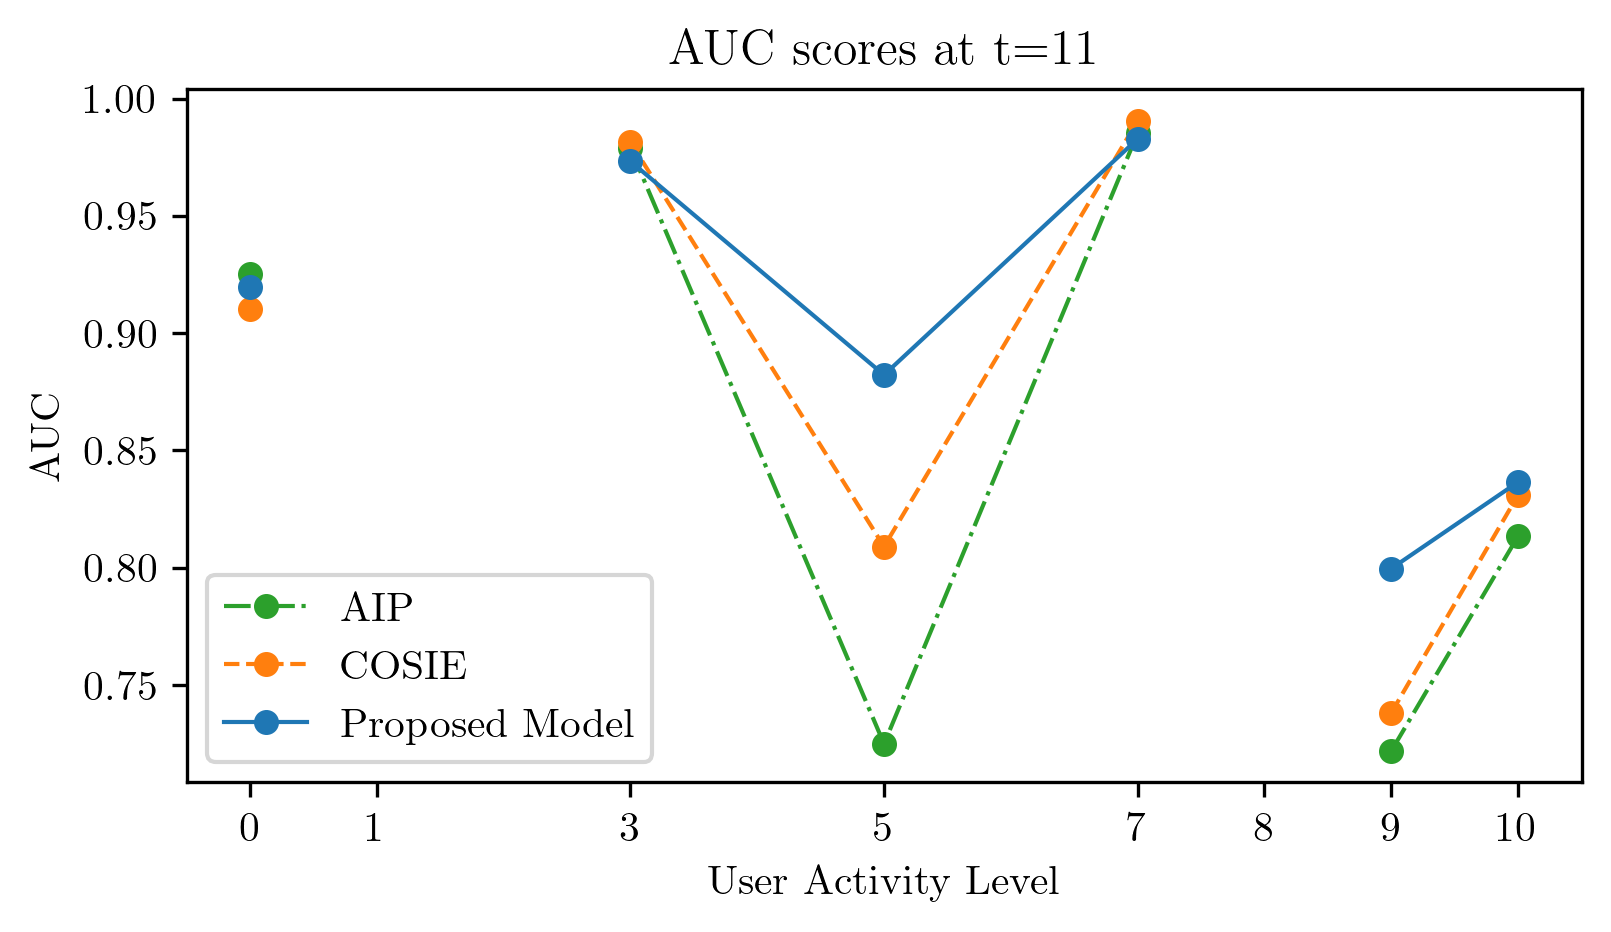

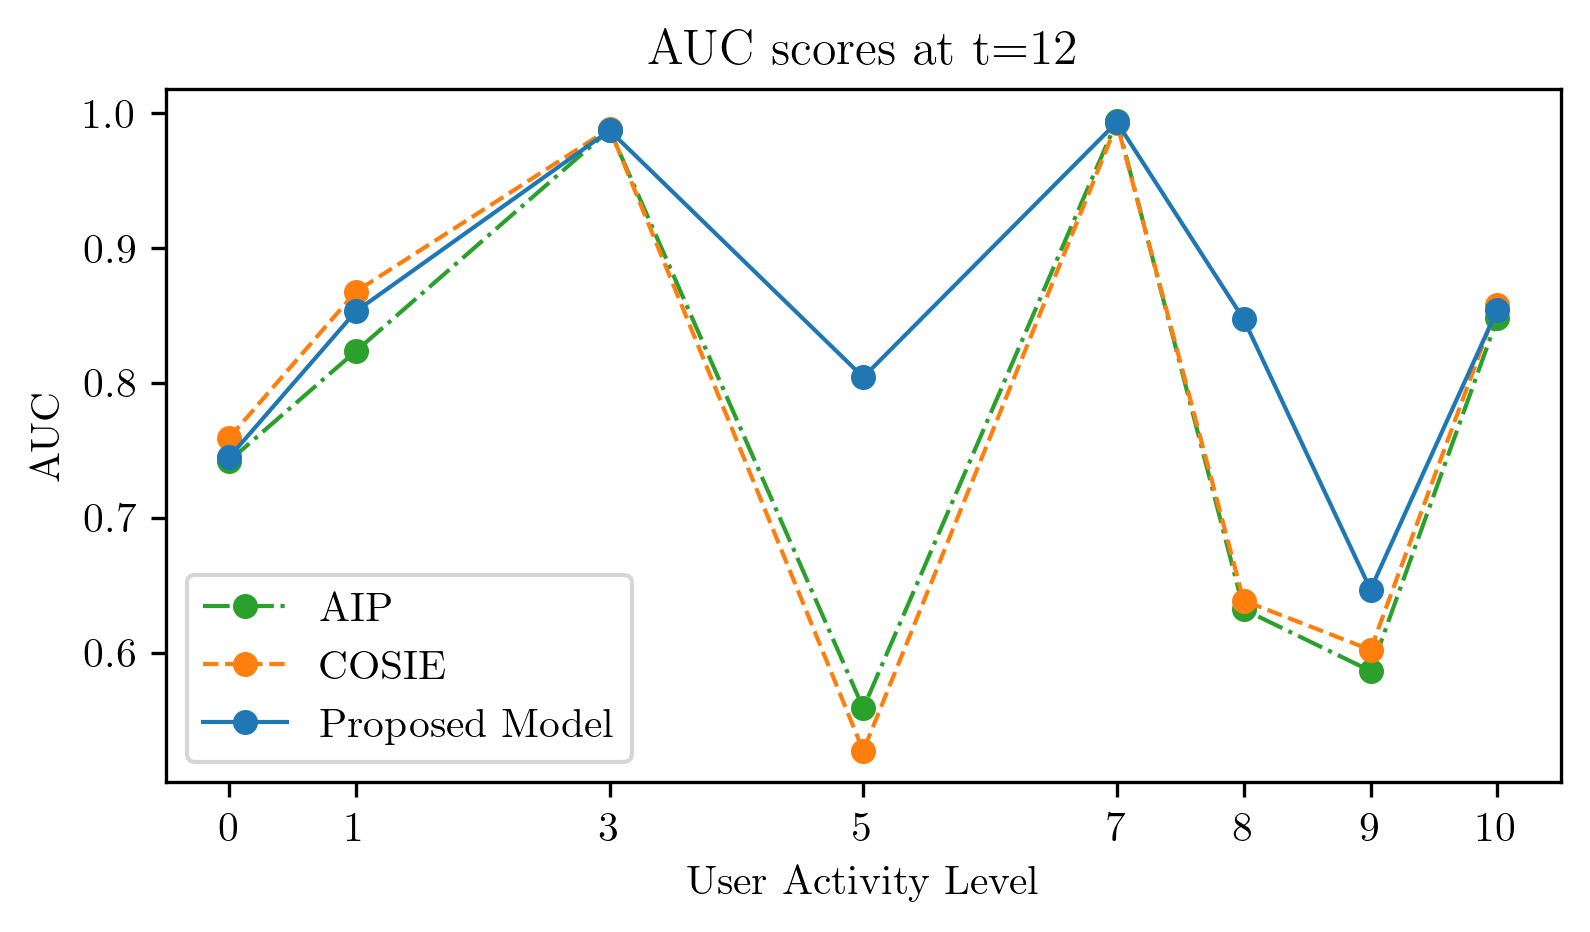

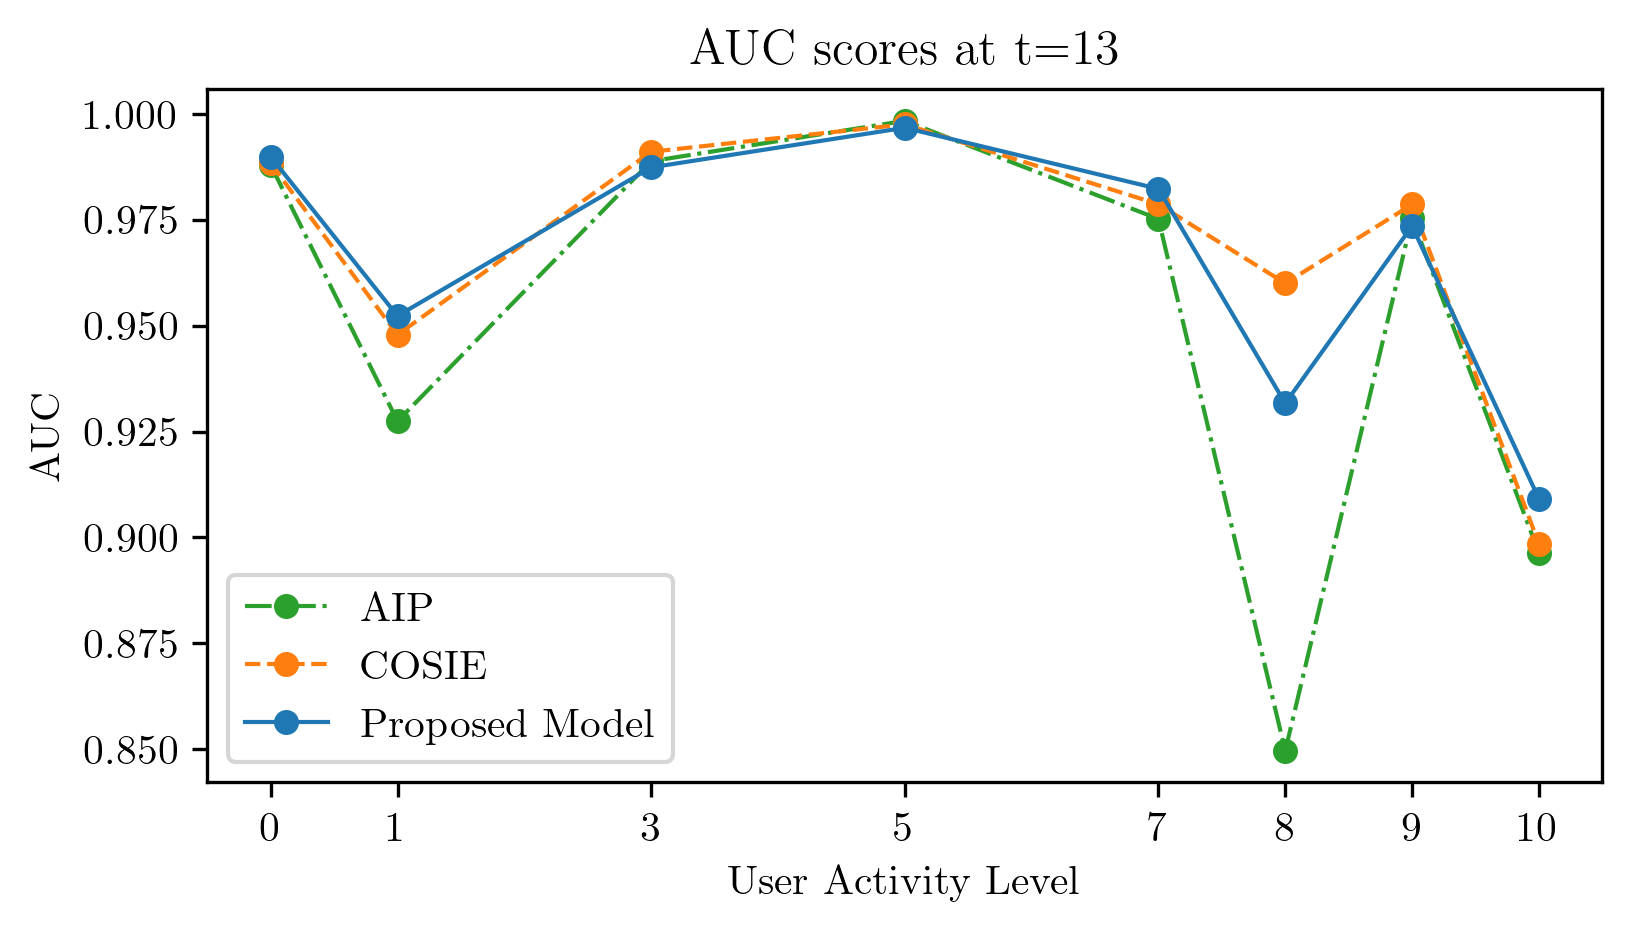

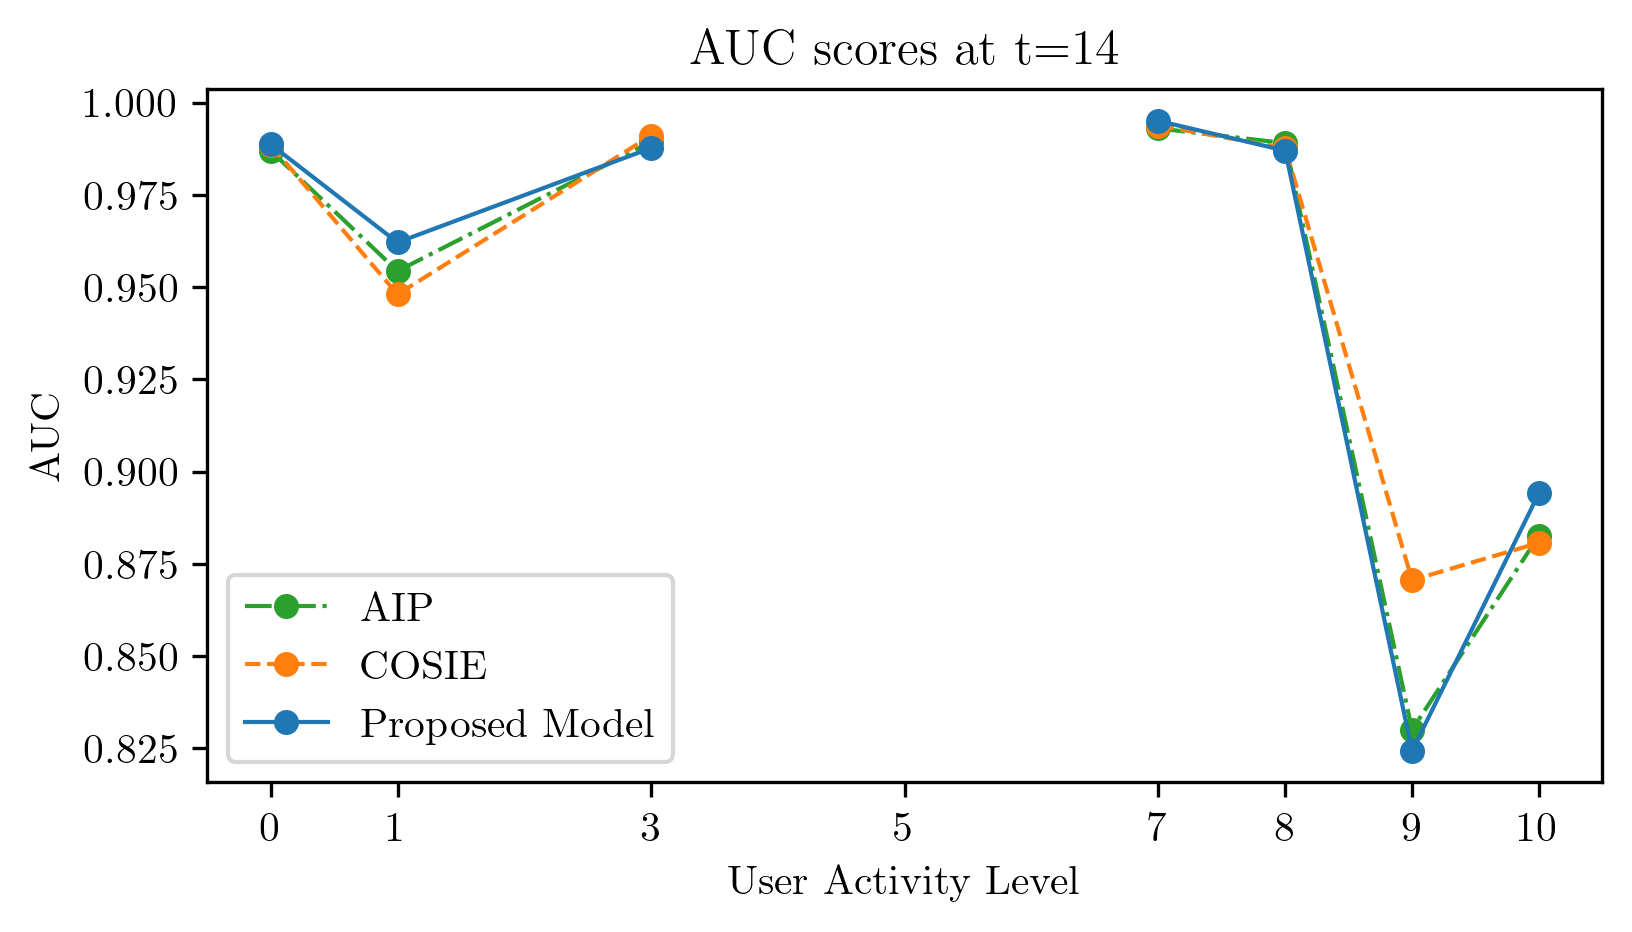

In [23]:
for time_step in range(num_test):
    plot_auc_values(
        range=nonzero_users_activity_levels,
        model_auc_values=model_auc_values_users[time_step],
        cosie_auc_values=cosie_auc_values_users[time_step],
        aip_auc_values=aip_auc_values_users[time_step],
        title=f"AUC scores at t={time_step + num_train + 1}",
        xlabel="User Activity Level",
        file_name=f"auc_users_{time_step + num_train + 1}.pdf",
    )

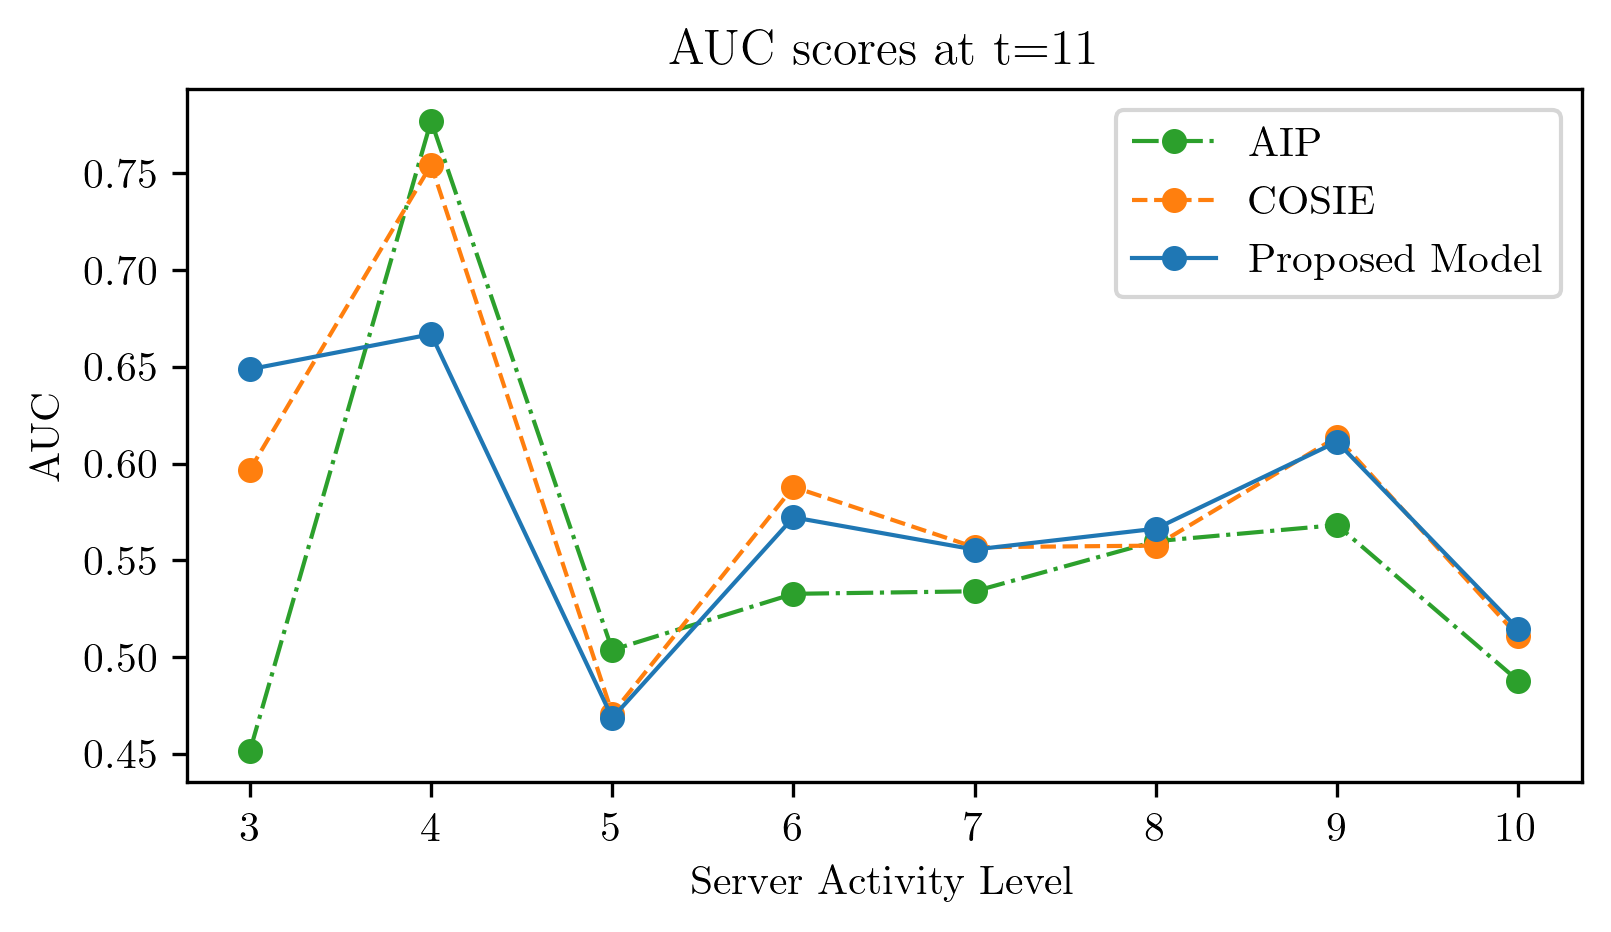

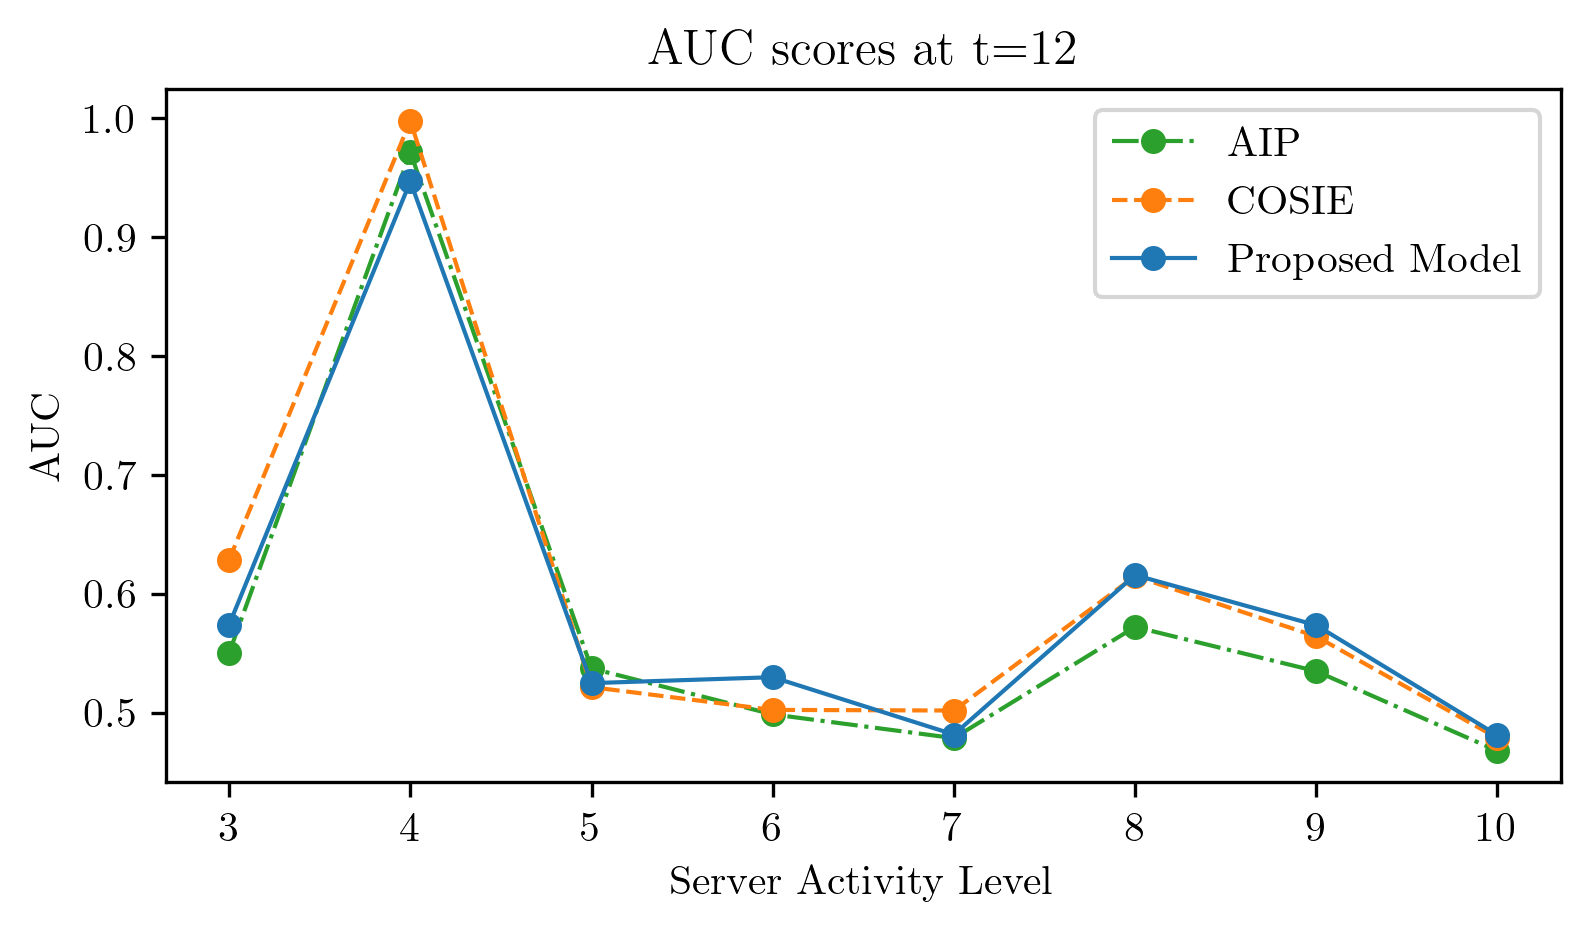

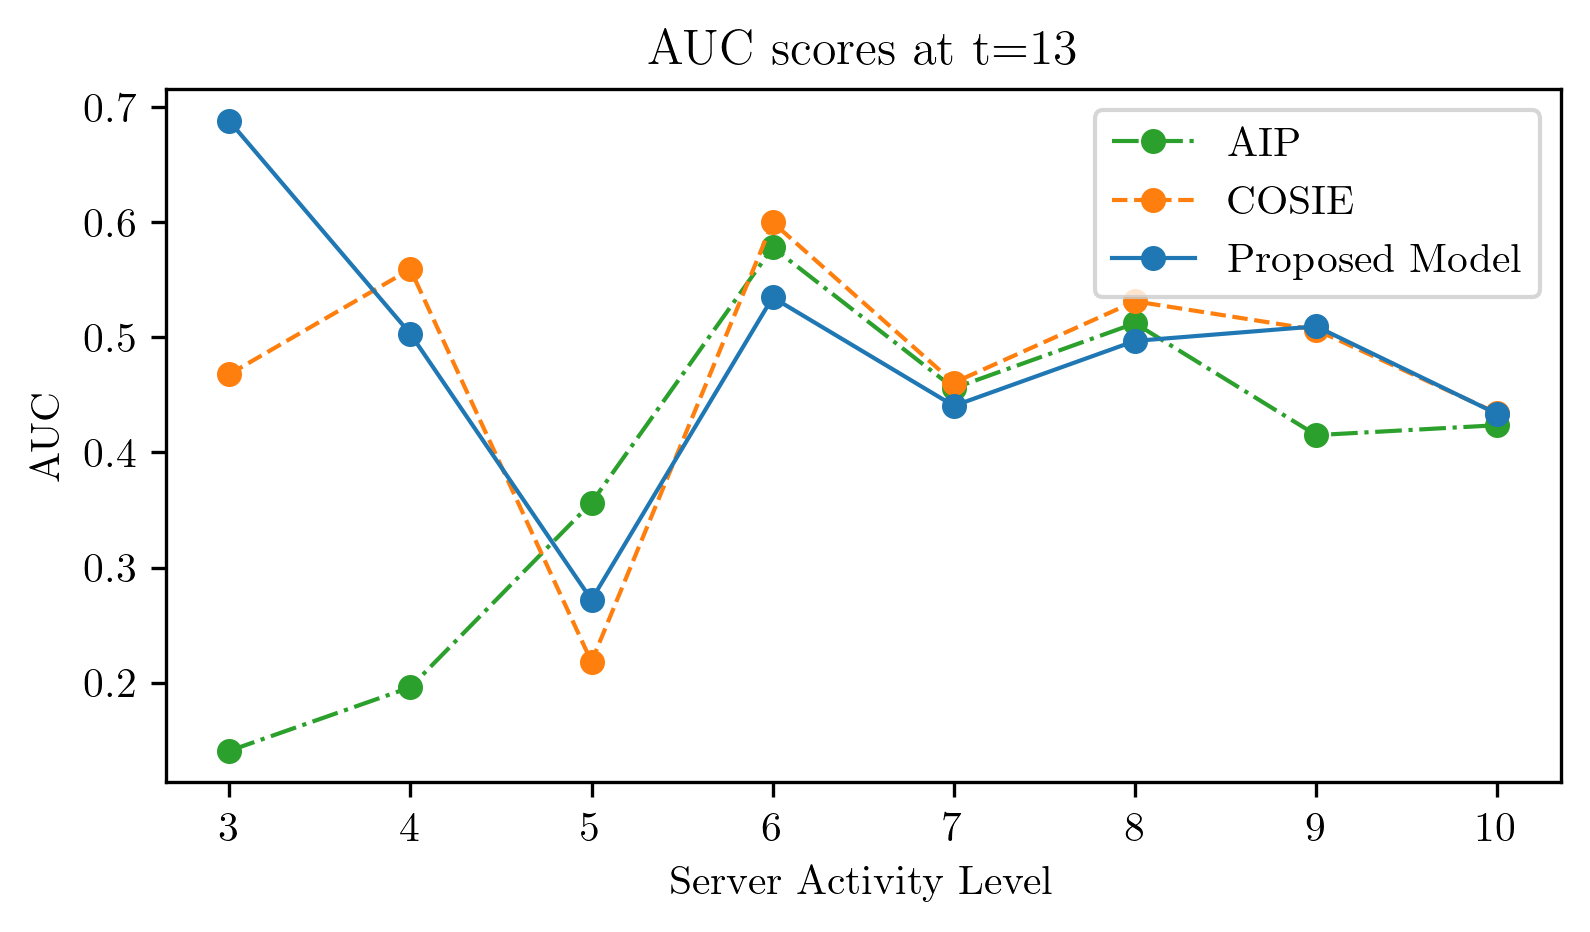

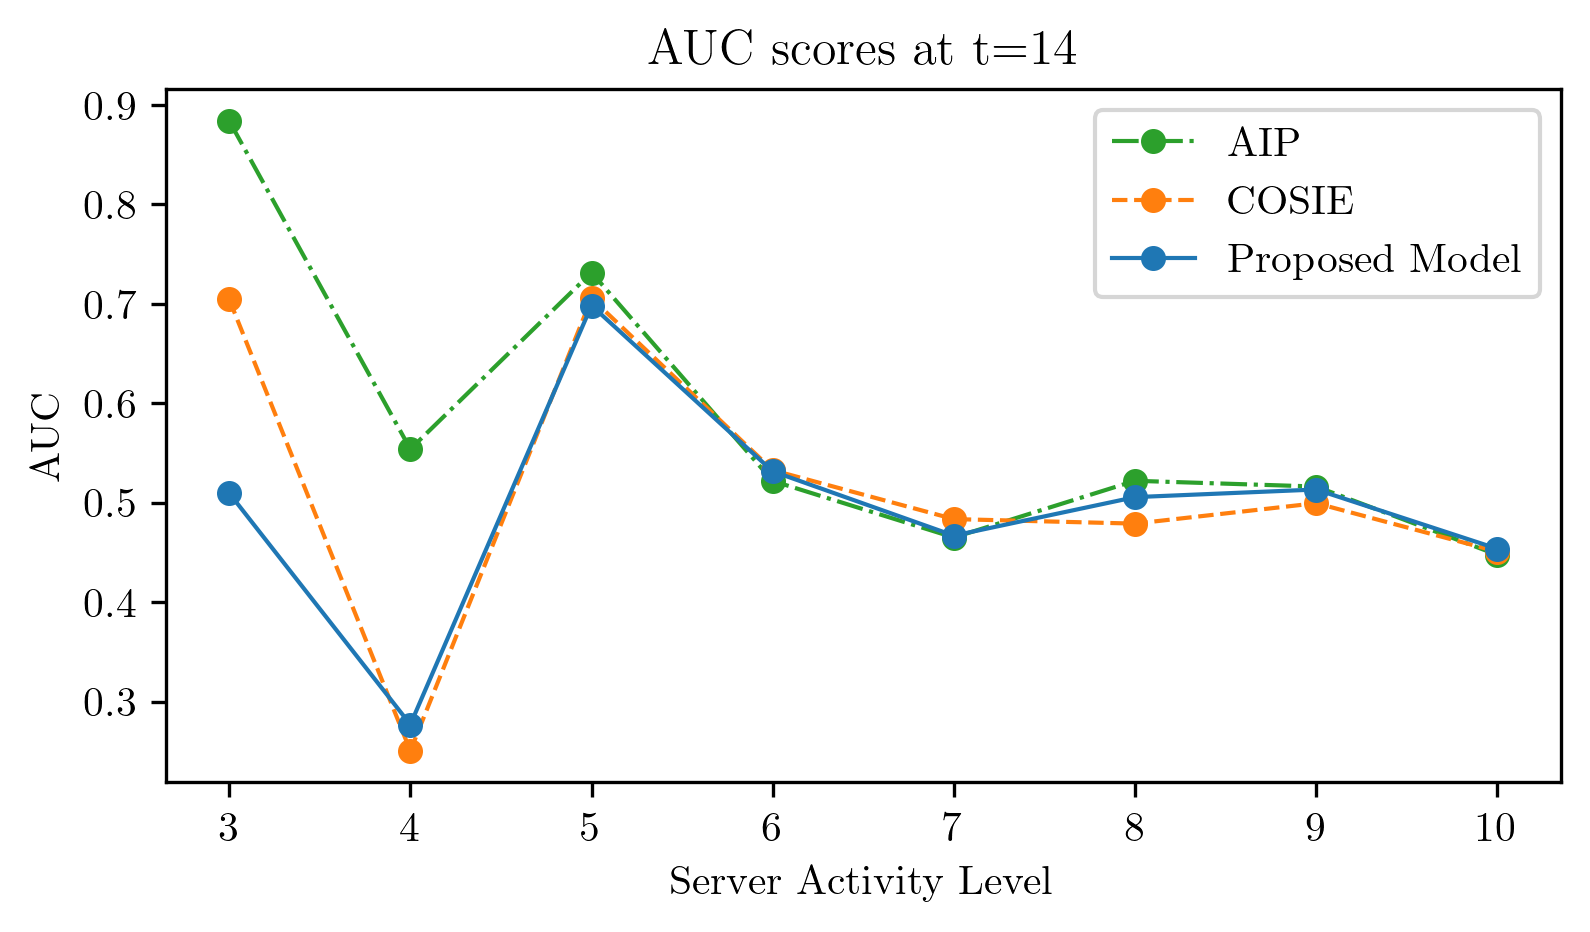

In [24]:
for time_step in range(num_test):
    plot_auc_values(
        range=nonzero_servers_activity_level,
        model_auc_values=model_auc_values_servers[time_step],
        cosie_auc_values=cosie_auc_values_servers[time_step],
        aip_auc_values=aip_auc_values_servers[time_step],
        title=f"AUC scores at t={time_step + num_train + 1}",
        xlabel="Server Activity Level",
        file_name=f"auc_servers_{time_step + num_train + 1}.pdf",
    )

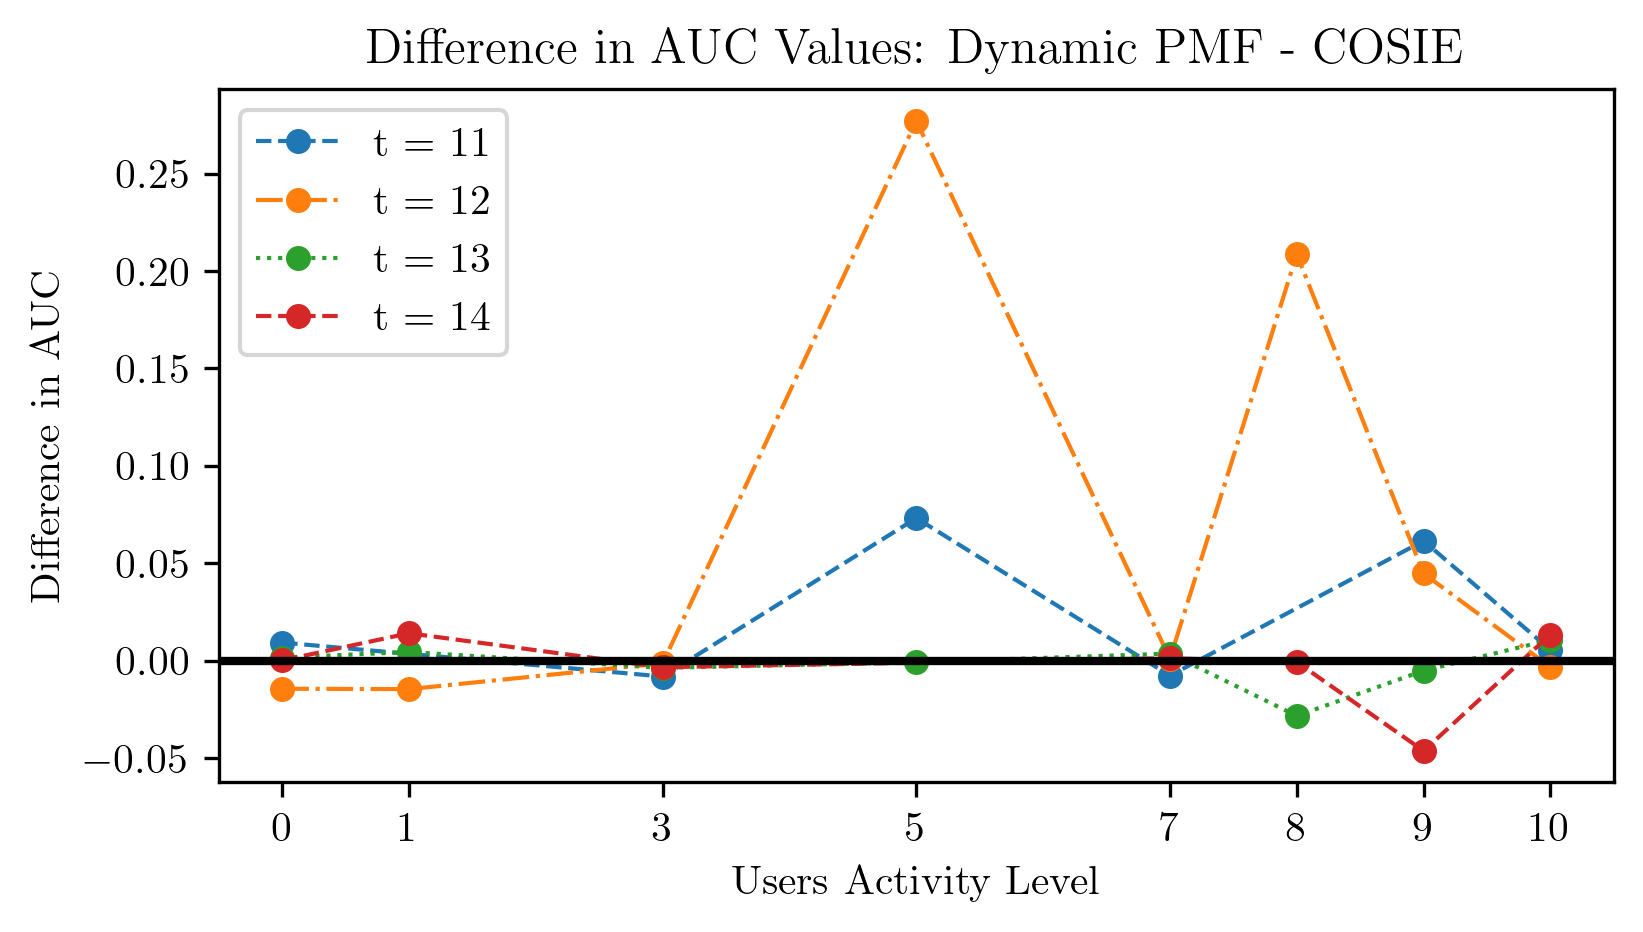

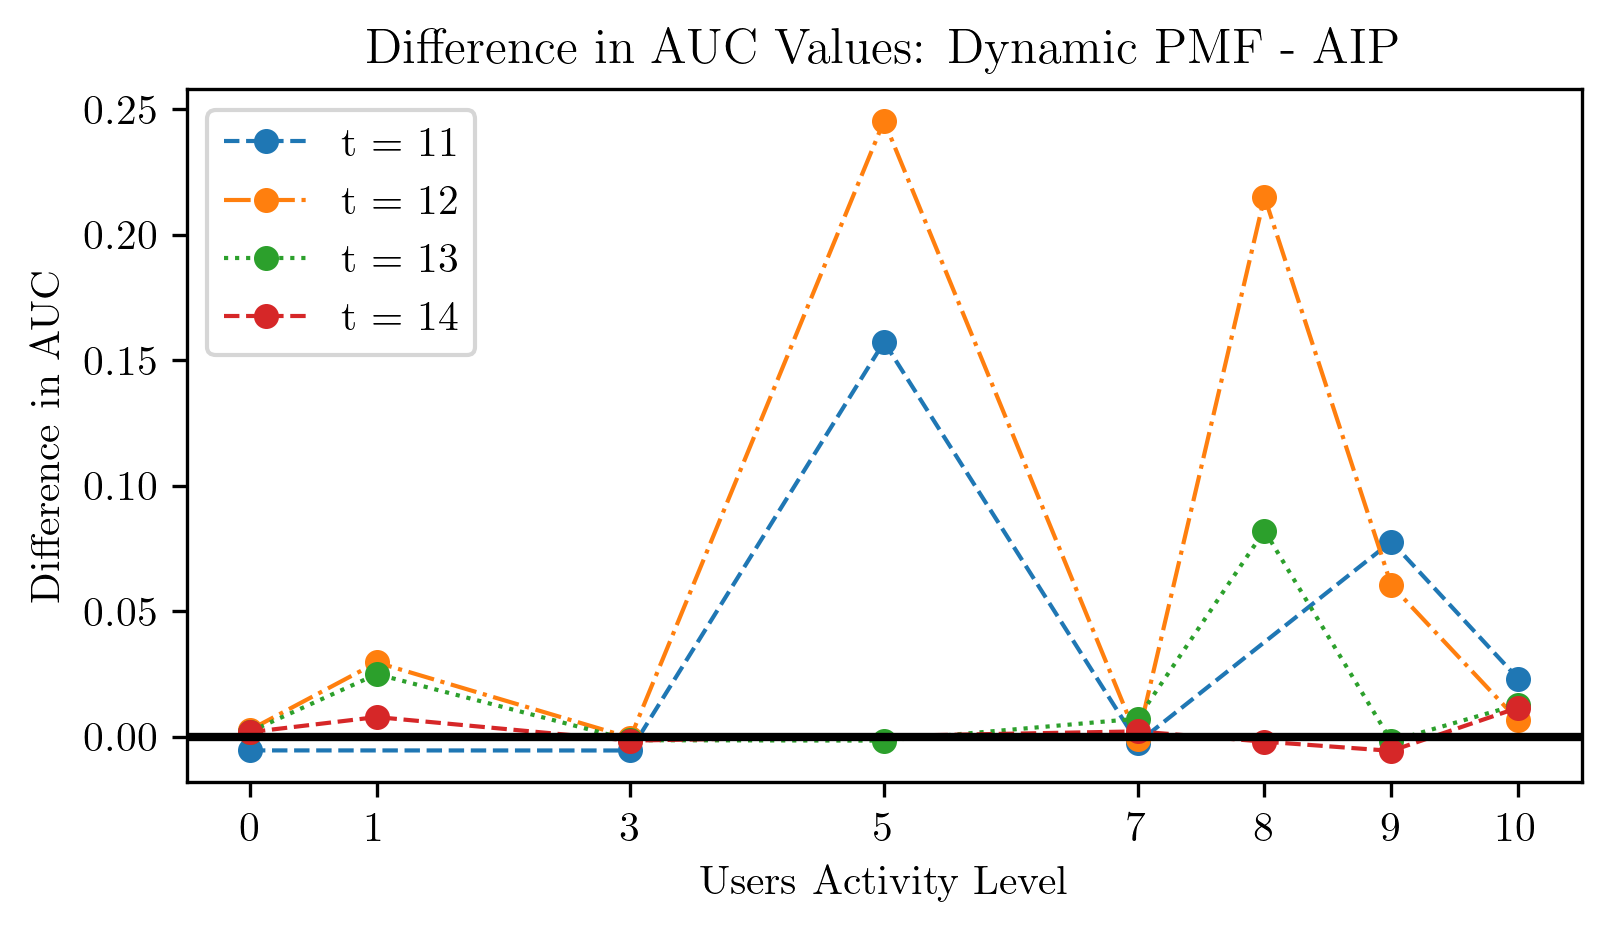

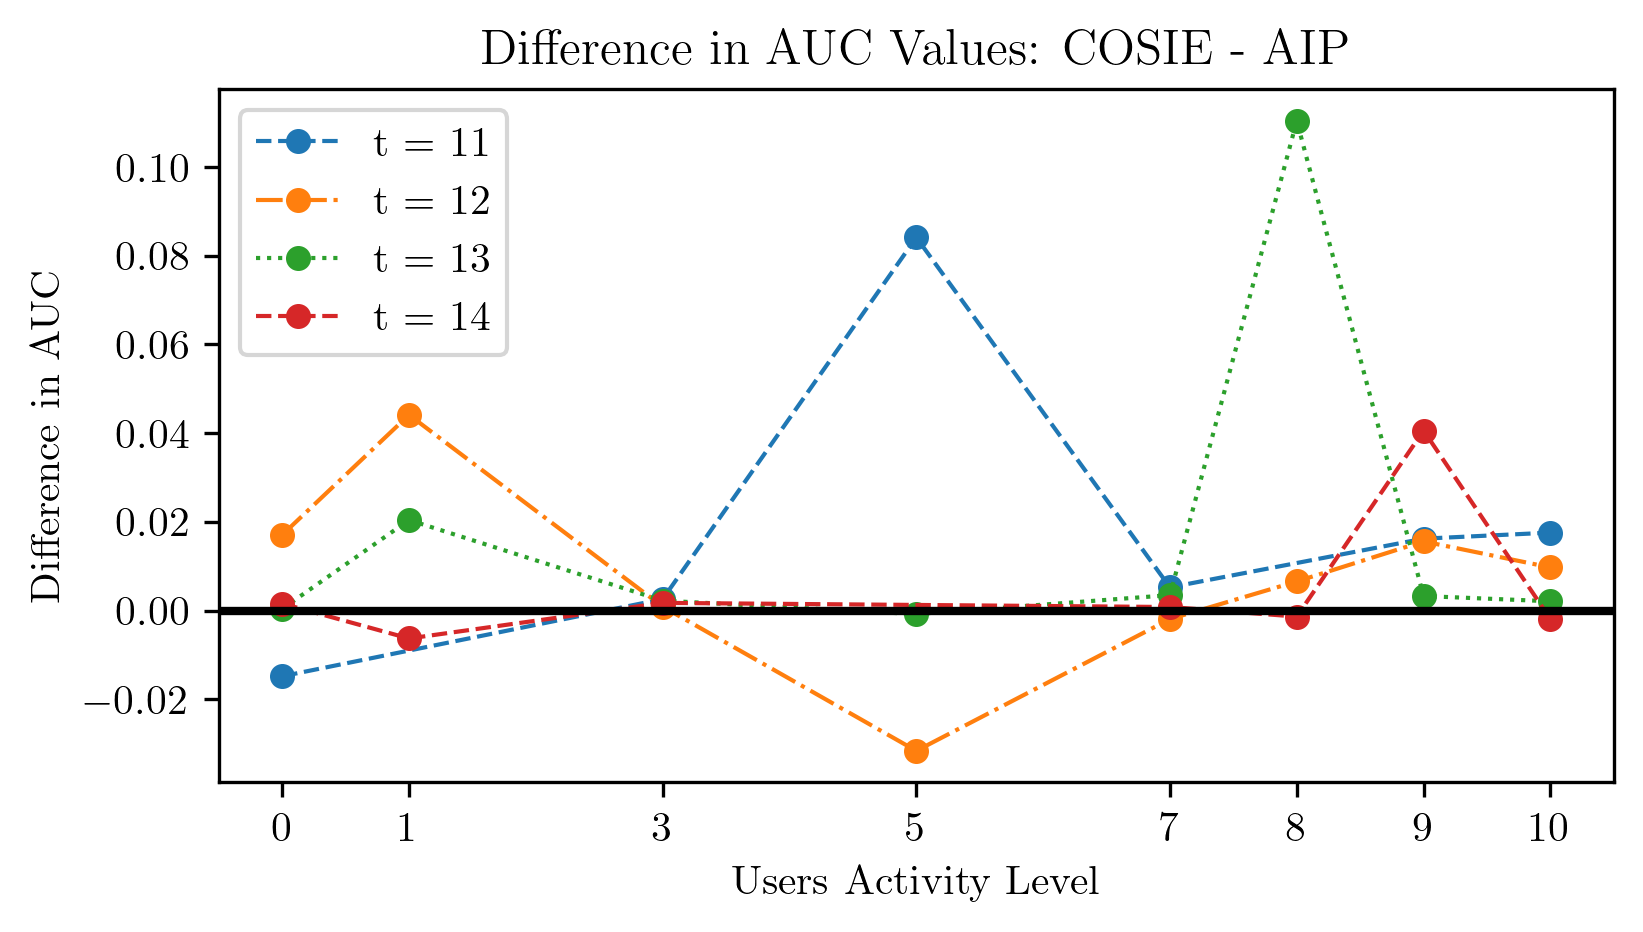

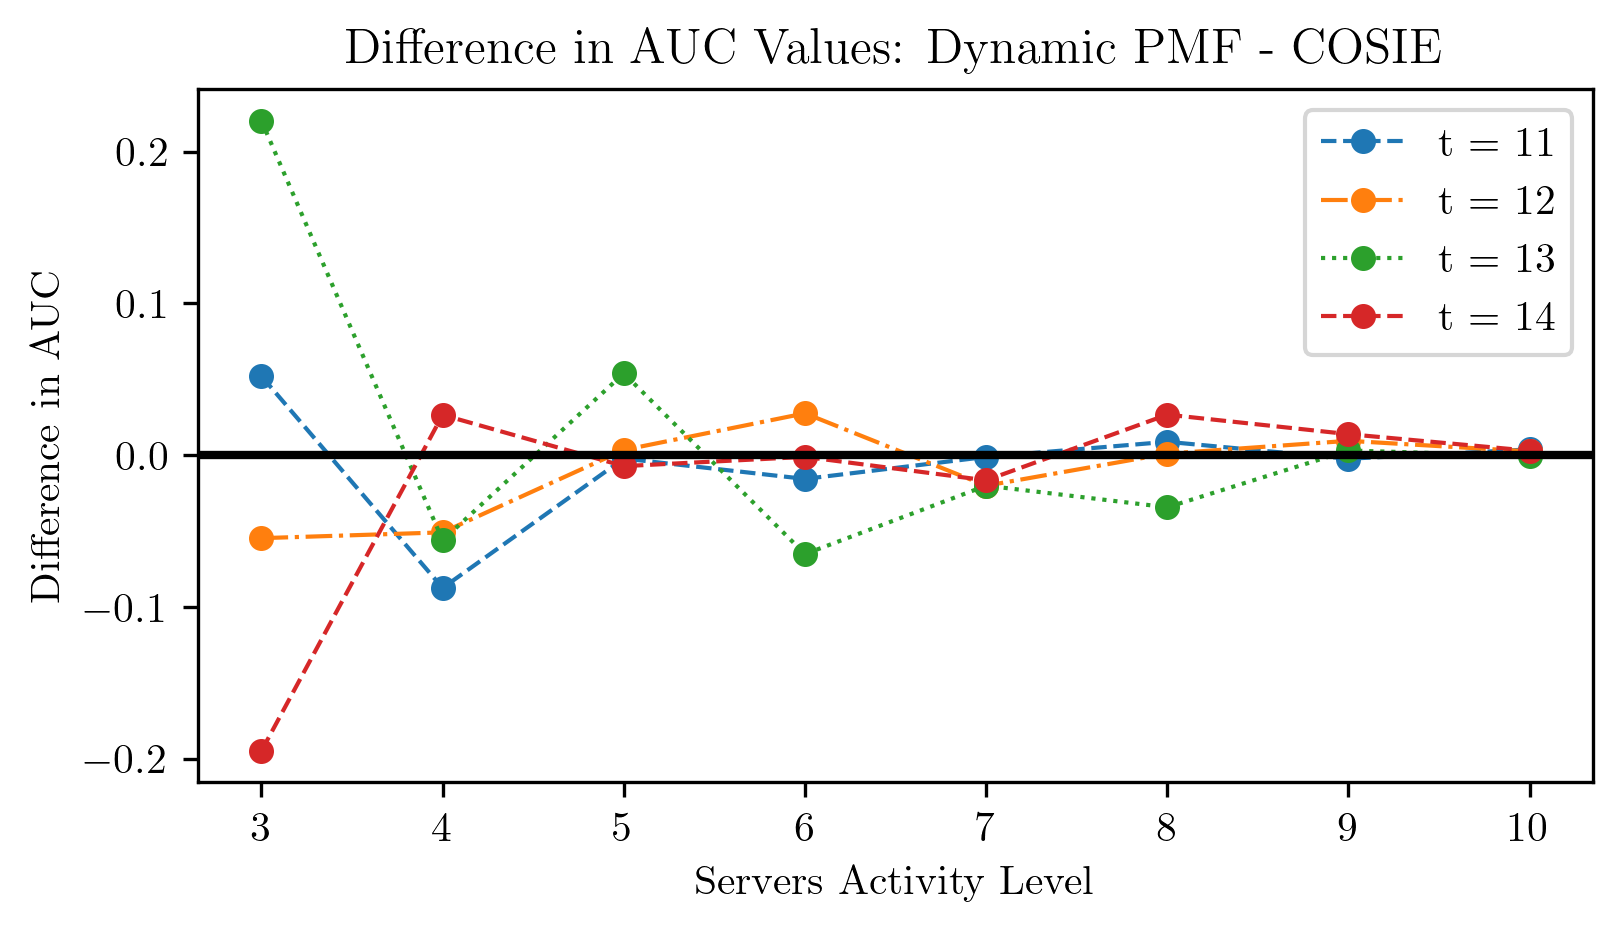

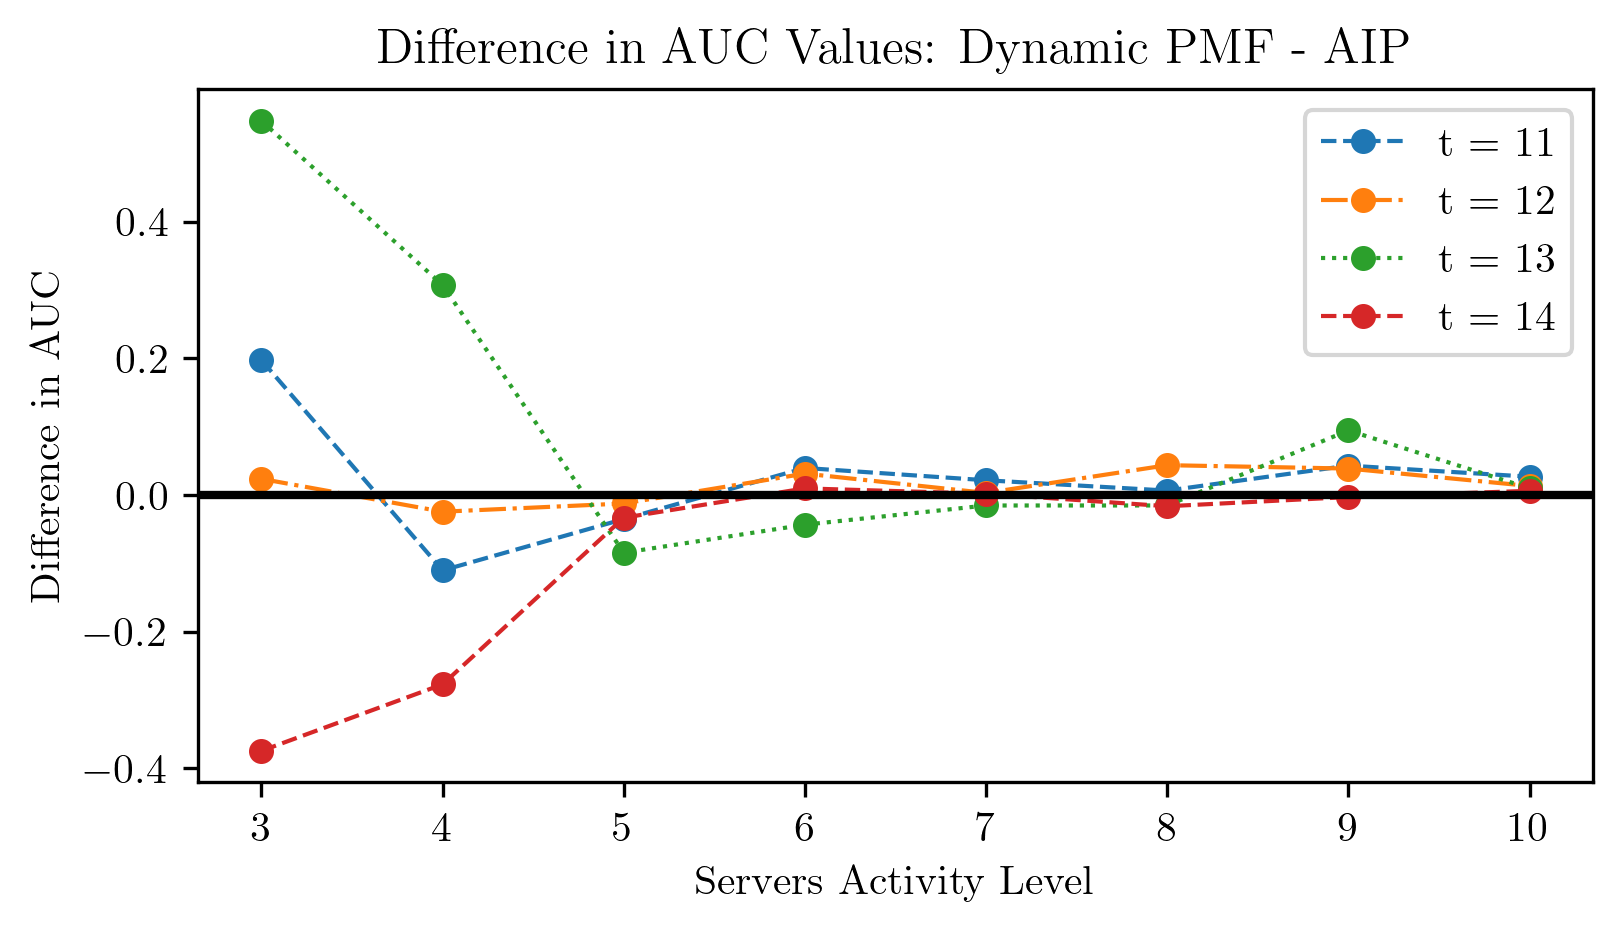

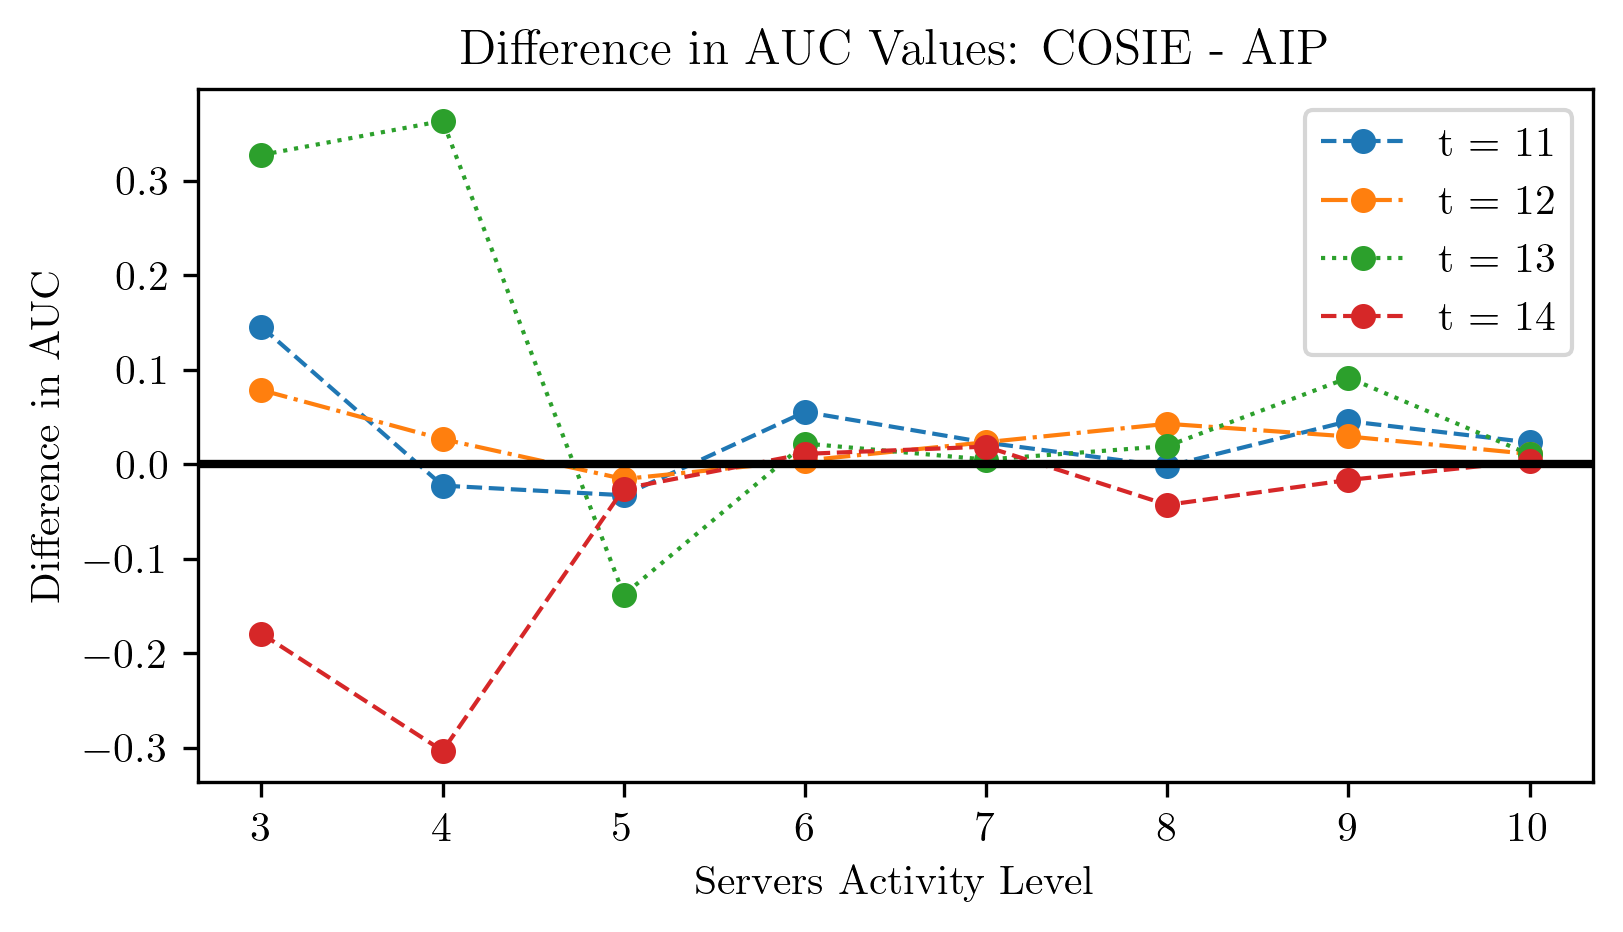

In [25]:
plot_diff_auc_values(
    nonzero_users_activity_levels,
    model_auc_values_users,
    cosie_auc_values_users,
    "Dynamic PMF - COSIE",
    "Users",
)
plot_diff_auc_values(
    nonzero_users_activity_levels,
    model_auc_values_users,
    aip_auc_values_users,
    "Dynamic PMF - AIP",
    "Users",
)
plot_diff_auc_values(
    nonzero_users_activity_levels,
    cosie_auc_values_users,
    aip_auc_values_users,
    "COSIE - AIP",
    "Users",
)

plot_diff_auc_values(
    nonzero_servers_activity_level,
    model_auc_values_servers,
    cosie_auc_values_servers,
    "Dynamic PMF - COSIE",
    "Servers",
)
plot_diff_auc_values(
    nonzero_servers_activity_level,
    model_auc_values_servers,
    aip_auc_values_servers,
    "Dynamic PMF - AIP",
    "Servers",
)
plot_diff_auc_values(
    nonzero_servers_activity_level,
    cosie_auc_values_servers,
    aip_auc_values_servers,
    "COSIE - AIP",
    "Servers",
)